In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sea
from scipy import stats
import matplotlib.pyplot as plt
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits, map_utils
from pathlib import Path

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
len(all_cities)

108

In [8]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_sites[city] = utils.load_site_inventory(city)
            cities_with_sites[city].relcapcty.sum()
        except Exception:
            pass

CPU times: user 13.6 s, sys: 345 ms, total: 13.9 s
Wall time: 14.2 s


In [9]:
len(cities_with_sites)

108

In [10]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city)
        except Exception:
            print(city, file=sys.stderr)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
Contra Costa County
Alameda County
Marin County
Saint Helena
Napa County
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Hillsborough
San Mateo County
Sonoma County


CPU times: user 3min 43s, sys: 5.15 s, total: 3min 48s
Wall time: 3min 55s


Solano County


In [11]:
len(cities_with_permits)

99

## Dump match results to JSON, for use in website

In [12]:
reload(utils)
reload(map_utils)
map_utils.write_matches_to_files(
    cities_with_sites,
    cities_with_permits,
    Path('./map_results')
)

100%|██████████| 108/108 [01:57<00:00,  1.09s/it]


## Data Cleaning Factoids

### Realistic Capacity

#### Pre-Existing Nulls

Two ways to calculate NA realistic capacities come to the same conclusion

In [13]:
rhna5 = sites_df[sites_df.rhnacyc == 'RHNA5']

In [14]:
rhna5.relcapcty[rhna5.relcapcty.isna()].shape

(2910,)

In [15]:
rhna5[(rhna5.relcapcty.str.contains("/^([^0-9]*)$/") != False)].shape

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(2910, 35)

In [16]:
rhna5.shape

(20849, 35)

In [17]:
2910 / rhna5.shape[0]

0.13957503957024317

### Proportion of nulls that are our fault versus theirs

In [18]:
for city, site in cities_with_sites.items():
    num_fail_parse_realcap = site.realcap_parse_fail.sum()
    num_fail_parse_allowden = site.allowden_parse_fail.sum()
    if num_fail_parse_realcap or num_fail_parse_allowden:
        print(city, end='\t')
    if num_fail_parse_realcap:
        print('Realcap', num_fail_parse_realcap)
    if num_fail_parse_allowden:
        print('Allowden', num_fail_parse_allowden)

San Ramon	Allowden 1
Newark	Allowden 1
Danville	Allowden 9
El Cerrito	Allowden 7
Walnut Creek	Allowden 90
Corte Madera	Allowden 1
Pittsburg	Allowden 1
Piedmont	Allowden 58
Sausalito	Allowden 87
Fairfax	Allowden 48
Novato	Allowden 5
Atherton	Allowden 2
Woodside	Allowden 266
San Mateo County	Allowden 136
Portola Valley	Allowden 8
Windsor	Allowden 1


In [19]:
sum([site.allowden_parse_fail.sum() for city, site in cities_with_sites.items()])

721

In [20]:
sum([site.realcap_parse_fail.sum() for city, site in cities_with_sites.items()])

0

In [21]:
sum([site.shape[0] for city, site in cities_with_permits.items()])

39871

In [22]:
721 / 39851

0.01809239416827683

In [23]:
sum([site.allowden_not_listed.sum() for city, site in cities_with_sites.items()])

5527

In [24]:
721 / (5547 + 721)

0.11502871729419273

11% of allowable density nulls are our fault. None of the realistic capacity nulls are our fault.

#### Degenerate Rows

In [25]:
no_realcap = pd.to_numeric(rhna5.relcapcty, errors='coerce') == 0
no_allowden = pd.to_numeric(rhna5.allowden, errors='coerce') == 0
no_locacreage = pd.to_numeric(rhna5.locacres, errors='coerce') == 0
no_gacreage = pd.to_numeric(rhna5.gacres, errors='coerce') == 0

In [26]:
rhna5[no_realcap & no_locacreage].shape

(14, 35)

In [27]:
rhna5[no_gacreage & no_locacreage].shape

(0, 35)

In [28]:
rhna5[no_gacreage].shape

(0, 35)

In [29]:
rhna5[no_realcap & no_allowden].shape

(901, 35)

In [30]:
rhna5[no_realcap & no_allowden & no_locacreage].shape

(0, 35)

I wouldn't say there are any degenerate rows. Even when locacreage is zero, we can rely on gacreage instead. 

There are, however, 901 sites with no realistic capacity and no allowable density. What kind of sites are these?

In [31]:
rhna5[no_realcap & no_allowden].jurisdict.value_counts()

San Francisco       884
Moraga               14
San Mateo County      2
Martinez              1
Name: jurisdict, dtype: int64

In [32]:
rhna5[no_realcap & no_allowden].sample(5, random_state =0)

objectid rhnacyc    rhnayrs county      jurisdict        apn  \
28077     70211   RHNA5  2015-2023   6075  San Francisco   4227/031   
30283     72417   RHNA5  2015-2023   6075  San Francisco  5434B/002   
33511     75645   RHNA5  2015-2023   6075  San Francisco   5333/029   
32095     74229   RHNA5  2015-2023   6075  San Francisco   5230/021   
31946     74080   RHNA5  2015-2023   6075  San Francisco   4811/011   

          locapn             genplan   zoning  gacres  ...  infcapcty  \
28077   4227/031  Central Waterfront  PDR-1-G   0.056  ...       None   
30283  5434B/002       BVHP Area A,B    PDR-2   0.697  ...       None   
33511   5333/029       BVHP Area A,B    PDR-2   0.057  ...       None   
32095   5230/021       BVHP Area A,B    PDR-2   1.122  ...       None   
31946   4811/011       BVHP Area A,B    PDR-2   0.229  ...       None   

       siteconst       sitetype  pdaparcel  bundled    existuse localnote  \
28077       None  Underutilized          Y     None    Dwelling      None   
30283       None  Underutilized          Y     None  Industrial      None   
33511       None  Underutilized          Y     None  Industrial      None   
32095       None         Vacant          Y     None      Vacant      None   
31946       None  Underutilized          Y     None  Industrial      None   

         Shape__Are Shape__Len  \
28077  2.312208e-08   0.000814   
30283  2.884321e-07   0.002368   
33511  2.374463e-08   0.000763   
32095  4.643043e-07   0.004282   
31946  9.496034e-08   0.001248   

                                                geometry  
28077  POLYGON ((-122.39100 37.75430, -122.39132 37.7...  
30283  POLYGON ((-122.39907 37.72771, -122.39941 37.7...  
33511  POLYGON ((-122.40177 37.73906, -122.40197 37.7...  
32095  POLYGON ((-122.39653 37.74671, -122.39660 37.7...  
31946  POLYGON ((-122.38719 37.72667, -122.38739 37.7...  

[5 rows x 35 columns]

They're mostly in San Francisco and have a zoning type of PDR. According to SF's website, "In order to protect PDR, residential development would be prohibited, while office, retail, and institutional uses (schools, hospitals, etc.) would be limited. HOWEVER, residences, offices and retail which currently exist legally in these areas may stay indefinitely."


In [33]:
sf_sites = cities_with_sites['San Francisco']
sf_sites_fixed = sf_sites[
    sf_sites['relcapcty'] != 0
]
cities_with_sites['San Francisco'] = sf_sites_fixed

In [34]:
sf_sites.shape

(5254, 30)

## Results

In [35]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [36]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [37]:
len(cities)

99

In [38]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

CPU times: user 31.6 s, sys: 972 ms, total: 32.6 s
Wall time: 33.6 s


In [39]:
results_df[results_df['P(dev) for inventory'].isna()]

City  Ratio of development on inventory sites  Mean overproduction  \
32       Orinda                                      NaN                  NaN   
64  Foster City                                      NaN                  NaN   

    Inventory housing / all housing  P(dev) for nonvacant sites  \
32                              0.0                         NaN   
64                              0.0                         NaN   

    P(dev) for vacant sites  P(dev) for inventory # nonvacant matches  \
32                      NaN                   NaN               0 / 0   
64                      NaN                   NaN               0 / 0   

   # vacant matches # matches  
32            0 / 0     0 / 0  
64            0 / 0     0 / 0

In [40]:
sites_df[sites_df.jurisdict == 'Orinda']

objectid rhnacyc    rhnayrs county jurisdict          apn       locapn  \
3167     45301   RHNA4  2007-2014   6013    Orinda  260-191-007  260-191-007   
3168     45302   RHNA4  2007-2014   6013    Orinda  260-200-017  260-200-017   
3169     45303   RHNA4  2007-2014   6013    Orinda  260-200-001  260-200-001   

                                                genplan  \
3167  Mixed-Use PD (13 acres) & Business and Profess...   
3168                              Public and Semipublic   
3169                           Residential Multi-family   

                                   zoning  gacres  ...  infcapcty  siteconst  \
3167                                   PD  11.001  ...       None       None   
3168       Public, Semipublic and Utility   1.455  ...       None       None   
3169  Residential Medium-Density District   9.277  ...       None       None   

      sitetype  pdaparcel  bundled  \
3167  Approved          Y     None   
3168    Vacant          Y     None   
3169    Vacant          Y     None   

                                               existuse  \
3167  OUSD offices, City and OUSD temporary corporat...   
3168                      Vacant fomer library building   
3169                                             Vacant   

                             localnote    Shape__Are Shape__Len  \
3167                              None  4.562342e-06   0.012552   
3168                              None  6.034702e-07   0.003162   
3169  want to rezone to allow 20 du/ac  3.847480e-06   0.008740   

                                               geometry  
3167  POLYGON ((-122.18291 37.88445, -122.18166 37.8...  
3168  POLYGON ((-122.18945 37.88495, -122.18938 37.8...  
3169  POLYGON ((-122.18350 37.88465, -122.18351 37.8...  

[3 rows x 35 columns]

In [41]:
for city, permits in cities_with_permits.items():
    print(city, '\t', round(utils.fraction_apns_nan(permits), 2))

Berkeley 	 0.01
Albany 	 0.01
Alameda 	 0.43
Livermore 	 0.01
Fremont 	 0.4
San Ramon 	 0.01
Newark 	 0.34
Brentwood 	 0.27
Hayward 	 0.29
Emeryville 	 0.14
Pleasanton 	 0.15
San Leandro 	 0.04
Concord 	 0.39
Richmond 	 0.02
Martinez 	 0.52
Clayton 	 0.75
Pinole 	 0.33
Oakland 	 0.33
San Francisco 	 0.19
Dublin 	 0.77
Antioch 	 0.25
Lafayette 	 0.03
Danville 	 0.32
San Pablo 	 0.19
Napa 	 0.21
El Cerrito 	 0.16
Union City 	 0.12
Walnut Creek 	 0.38
Corte Madera 	 0.05
Moraga 	 0.06
Hercules 	 0.23
Oakley 	 0.25
Orinda 	 0.18
Pittsburg 	 0.53
Pleasant Hill 	 0.38
American Canyon 	 0.56
Larkspur 	 0.51
Piedmont 	 0.0
San Rafael 	 0.02
Calistoga 	 0.12
Tiburon 	 0.0
Sausalito 	 0.36
Yountville 	 0.27
San Anselmo 	 0.29
Belvedere 	 0.43
Fairfax 	 0.06
Ross 	 0.17
Novato 	 0.2
Half Moon Bay 	 0.25
Millbrae 	 0.22
San Bruno 	 0.08
Mill Valley 	 0.31
Brisbane 	 0.54
Atherton 	 0.18
Menlo Park 	 0.42
Pacifica 	 0.0
Redwood City 	 0.13
Belmont 	 0.09
San Mateo 	 0.15
Colma 	 0.23
Daly City 	 0.

In [42]:
cities_with_permits['Dublin'].apn.isna().mean()

0.7659944367176634

Text(0.5, 1.0, 'Are missing APNs skewing our results?')

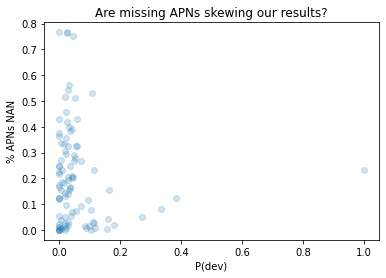

In [43]:
x = results_df["P(dev) for inventory"]
y = [utils.fraction_apns_nan(p) for c, p in cities_with_permits.items()]
plt.scatter(x, y, alpha=.2)
plt.xlabel("P(dev)")
plt.ylabel("% APNs NAN")
plt.title("Are missing APNs skewing our results?")

In [44]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

CPU times: user 3min 8s, sys: 7.24 s, total: 3min 15s
Wall time: 3min 20s


In [45]:
results_geo_df.round(3)

City  Ratio of development on inventory sites  \
0       Berkeley                                    0.348   
1         Albany                                    0.634   
2        Alameda                                    0.535   
3      Livermore                                    0.577   
4        Fremont                                    0.876   
..           ...                                      ...   
94  Monte Sereno                                    1.424   
95    Healdsburg                                    0.511   
96     Fairfield                                    0.320   
97        Sonoma                                    0.182   
98       Windsor                                    0.162   

    Mean overproduction  Inventory housing / all housing  \
0                 1.255                            0.041   
1                   NaN                            0.000   
2                   NaN                            0.000   
3                 1.238                            0.245   
4                 0.438                            0.112   
..                  ...                              ...   
94                  NaN                            0.000   
95                0.279                            0.028   
96                0.300                            0.001   
97                0.103                            0.029   
98                  NaN                            0.025   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
0                        0.018                    0.013                 0.015   
1                        0.000                    0.000                 0.000   
2                        0.143                    0.273                 0.222   
3                        0.051                    0.175                 0.114   
4                        0.050                    0.095                 0.056   
..                         ...                      ...                   ...   
94                       0.000                      NaN                 0.000   
95                       0.042                    0.056                 0.050   
96                       0.000                    0.039                 0.035   
97                       0.000                    0.200                 0.043   
98                       0.426                    0.000                 0.392   

   # nonvacant matches # vacant matches # matches  
0              3 / 167          3 / 237   6 / 404  
1               0 / 33            0 / 8    0 / 41  
2                1 / 7           3 / 11    4 / 18  
3               5 / 99         18 / 103  23 / 202  
4              7 / 141           2 / 21   9 / 162  
..                 ...              ...       ...  
94               0 / 6            0 / 0     0 / 6  
95              1 / 24           2 / 36    3 / 60  
96               0 / 9           3 / 77    3 / 86  
97              0 / 18            1 / 5    1 / 23  
98             20 / 47            0 / 4   20 / 51  

[99 rows x 10 columns]

In [46]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

CPU times: user 3min, sys: 6.99 s, total: 3min 7s
Wall time: 3min 11s


In [47]:
results_both_df.round(3)

City  Ratio of development on inventory sites  \
0       Berkeley                                    0.348   
1         Albany                                    0.634   
2        Alameda                                    0.535   
3      Livermore                                    0.577   
4        Fremont                                    0.876   
..           ...                                      ...   
94  Monte Sereno                                    1.424   
95    Healdsburg                                    0.511   
96     Fairfield                                    0.320   
97        Sonoma                                    0.182   
98       Windsor                                    0.162   

    Mean overproduction  Inventory housing / all housing  \
0                 1.255                            0.041   
1                   NaN                            0.000   
2                   NaN                            0.000   
3                 1.238                            0.245   
4                 0.438                            0.112   
..                  ...                              ...   
94                  NaN                            0.000   
95                0.279                            0.028   
96                0.300                            0.001   
97                0.103                            0.029   
98                  NaN                            0.025   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
0                        0.018                    0.025                 0.022   
1                        0.000                    0.000                 0.000   
2                        0.143                    0.273                 0.222   
3                        0.091                    0.233                 0.163   
4                        0.050                    0.095                 0.056   
..                         ...                      ...                   ...   
94                       0.000                      NaN                 0.000   
95                       0.083                    0.083                 0.083   
96                       0.000                    0.039                 0.035   
97                       0.000                    0.200                 0.043   
98                       0.426                    0.000                 0.392   

   # nonvacant matches # vacant matches # matches  
0              3 / 167          6 / 237   9 / 404  
1               0 / 33            0 / 8    0 / 41  
2                1 / 7           3 / 11    4 / 18  
3               9 / 99         24 / 103  33 / 202  
4              7 / 141           2 / 21   9 / 162  
..                 ...              ...       ...  
94               0 / 6            0 / 0     0 / 6  
95              2 / 24           3 / 36    5 / 60  
96               0 / 9           3 / 77    3 / 86  
97              0 / 18            1 / 5    1 / 23  
98             20 / 47            0 / 4   20 / 51  

[99 rows x 10 columns]

### Histograms of QOIs

In [48]:
results_df[results_df['P(dev) for inventory'] == 0].City.values

array(['Albany', 'Alameda', 'Antioch', 'Union City', 'Walnut Creek',
       'Moraga', 'Hercules', 'Oakley', 'Tiburon', 'Sausalito', 'Ross',
       'Millbrae', 'Pacifica', 'Gilroy', 'East Palo Alto', 'Los Gatos',
       'Saratoga', 'Rohnert Park', 'Suisun City', 'Rio Vista',
       'Monte Sereno'], dtype=object)

In [49]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

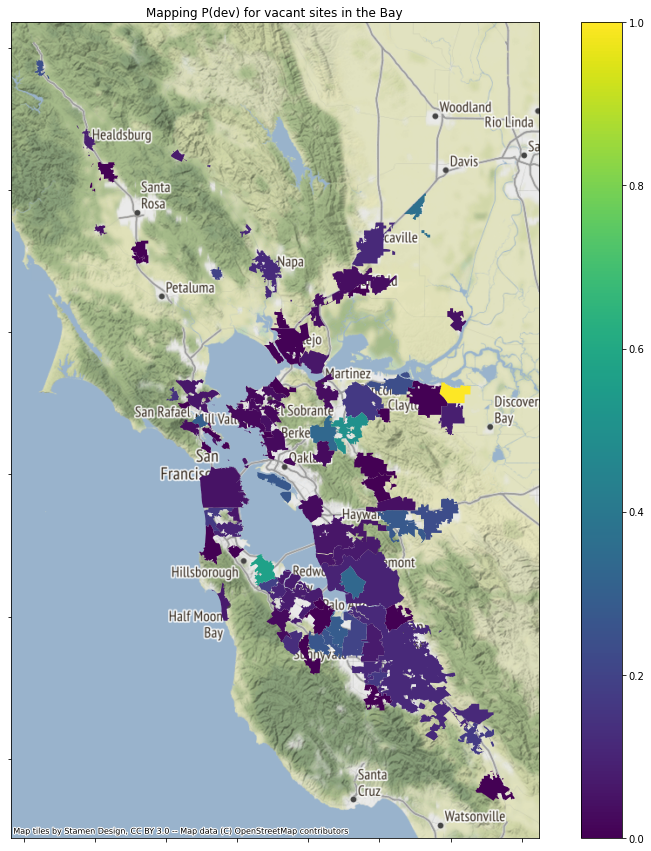

In [50]:
utils.map_qoi('P(dev) for vacant sites', results_both_df)

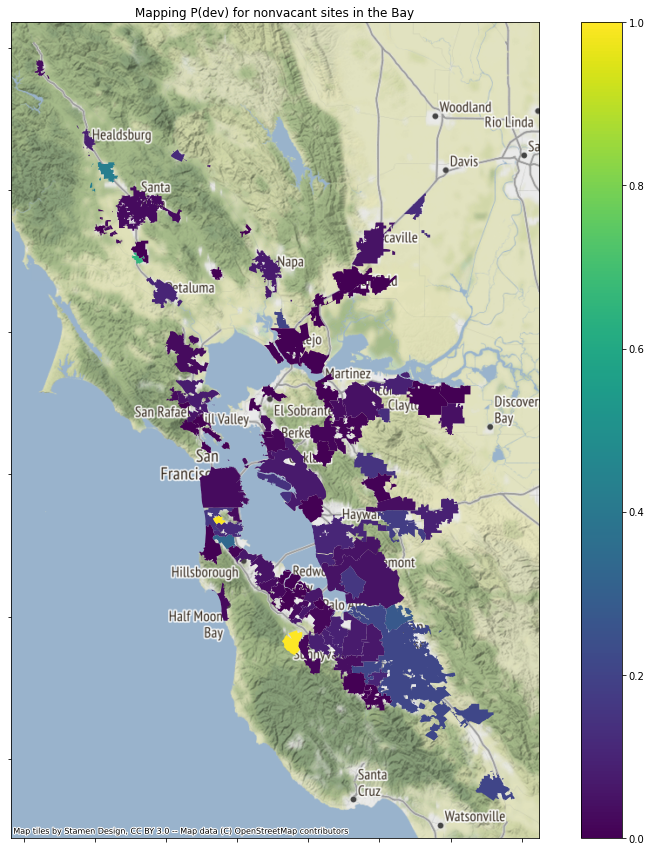

In [51]:
utils.map_qoi('P(dev) for nonvacant sites', results_both_df)

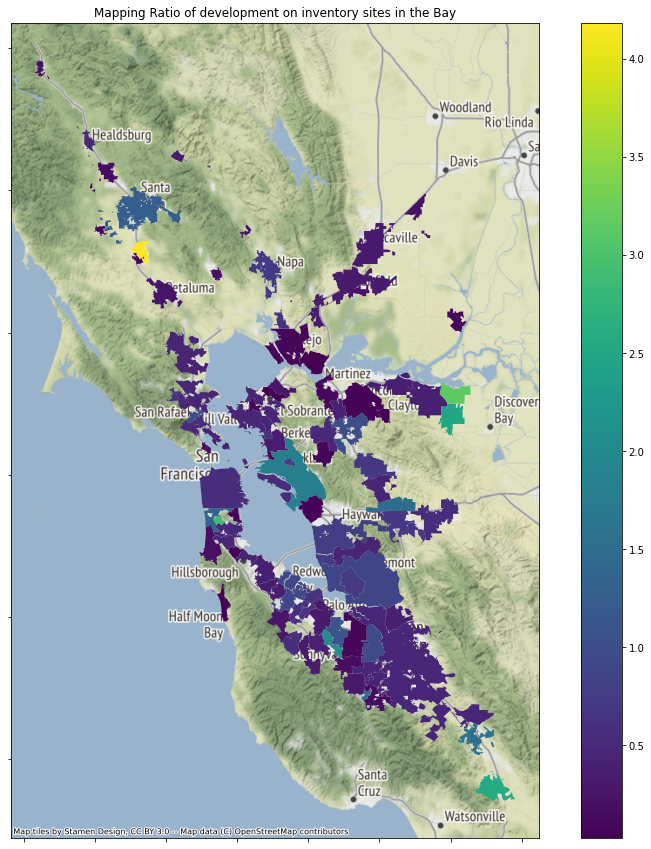

In [52]:
utils.map_qoi('Ratio of development on inventory sites', results_both_df)

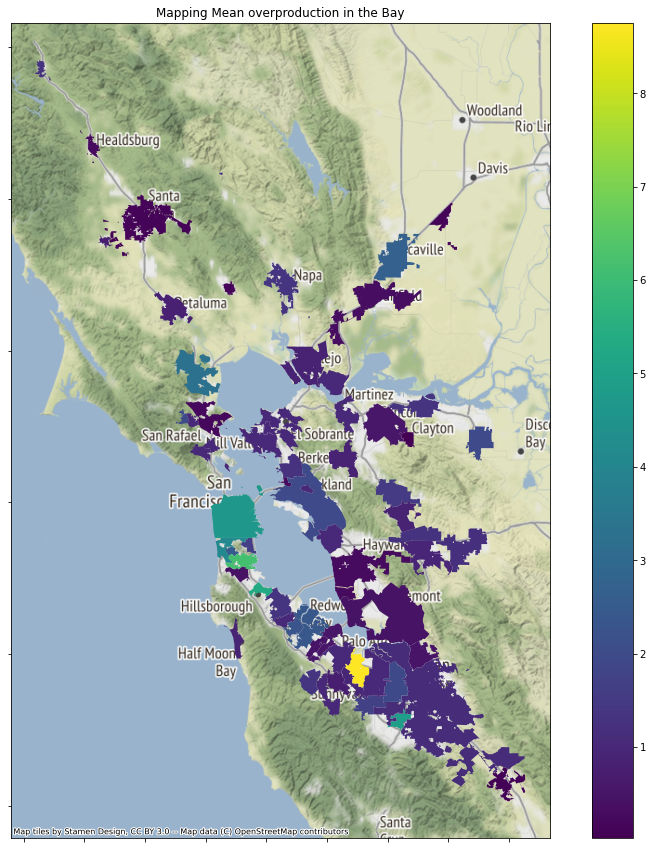

In [53]:
utils.map_qoi('Mean overproduction', results_both_df)

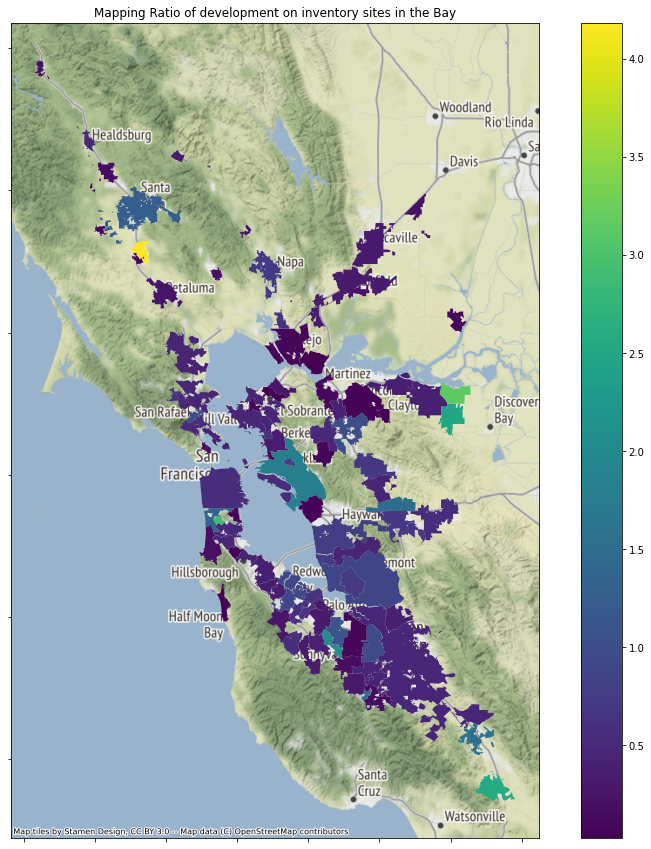

In [54]:
utils.map_qoi('Ratio of development on inventory sites', results_both_df)

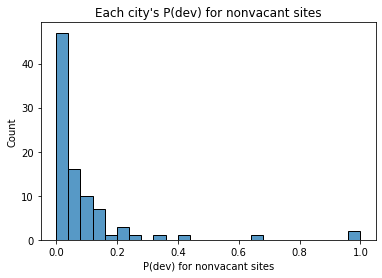

In [55]:
sea_plot = sea.histplot(results_both_df['P(dev) for nonvacant sites']).set_title("Each city's P(dev) for nonvacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_nonvacant.png')

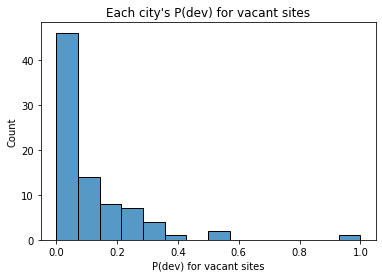

In [56]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev) for vacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_vacant.png')

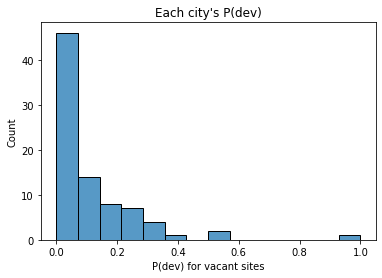

In [57]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev)")
sea_plot.get_figure().savefig('./figures/Pdev.png')

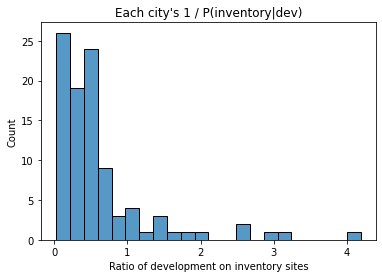

In [58]:
sea_plot = sea.histplot(results_both_df['Ratio of development on inventory sites']).set_title("Each city's 1 / P(inventory|dev)")
sea_plot.get_figure().savefig('./figures/ratio_of_dev.png')

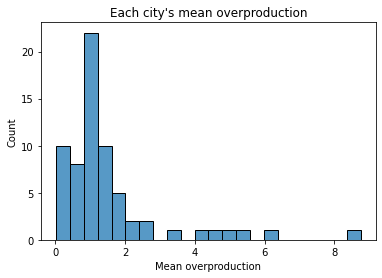

In [59]:
sea_plot = sea.histplot(results_both_df['Mean overproduction']).set_title("Each city's mean overproduction")
sea_plot.get_figure().savefig('./figures/mean_overproduction.png')

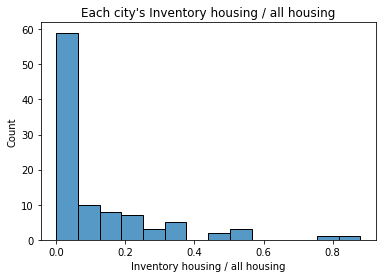

In [60]:
sea_plot = sea.histplot(results_both_df['Inventory housing / all housing']).set_title("Each city's Inventory housing / all housing")
sea_plot.get_figure().savefig('./figures/inventory_housing_over_all_housing.png')


### Did RHNA success in last cycle actually have anything to do with how good the site inventory was?

In [61]:
rhna_success = results_both_df['Ratio of development on inventory sites']
p_dev = results_both_df['P(dev) for inventory']

is_null = np.isnan(rhna_success) | np.isnan(p_dev)
stats.pearsonr(rhna_success[~is_null], p_dev[~is_null])

(0.28144959783308565, 0.005226819019963483)

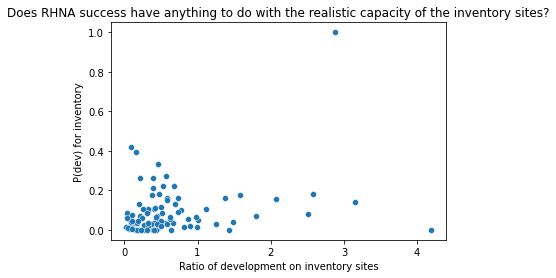

In [62]:
sea_plot = sea.scatterplot(x=rhna_success[~is_null], y=p_dev[~is_null])
sea_plot.set_title("Does RHNA success have anything to do with the realistic capacity of the inventory sites?")
sea_plot.get_figure().savefig('./figures/did_realistic_capacity_calcs_matter.png')

### Table of top 10 cities by P(dev) & bottom 10

#### Worst

In [63]:
results_both_df.sort_values(by='P(dev) for inventory').head(10)

City  Ratio of development on inventory sites  \
1           Albany                                 0.633907   
94    Monte Sereno                                 1.424242   
89     Suisun City                                 0.221392   
87    Rohnert Park                                 4.184211   
81        Saratoga                                 0.307407   
30        Hercules                                 0.271691   
73       Los Gatos                                 0.167296   
67  East Palo Alto                                 0.315542   
20         Antioch                                 0.394536   
40         Tiburon                                 0.428571   

    Mean overproduction  Inventory housing / all housing  \
1                   NaN                              0.0   
94                  NaN                              0.0   
89                  NaN                              0.0   
87                  NaN                              0.0   
81                  NaN                              0.0   
30                  NaN                              0.0   
73                  NaN                              0.0   
67                  NaN                              0.0   
20                  NaN                              0.0   
40                  NaN                              0.0   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
1                          0.0                      0.0                   0.0   
94                         0.0                      NaN                   0.0   
89                         0.0                      0.0                   0.0   
87                         0.0                      0.0                   0.0   
81                         0.0                      NaN                   0.0   
30                         NaN                      0.0                   0.0   
73                         0.0                      0.0                   0.0   
67                         0.0                      0.0                   0.0   
20                         0.0                      0.0                   0.0   
40                         0.0                      0.0                   0.0   

   # nonvacant matches # vacant matches # matches  
1               0 / 33            0 / 8    0 / 41  
94               0 / 6            0 / 0     0 / 6  
89               0 / 5           0 / 31    0 / 36  
87              0 / 34            0 / 1    0 / 35  
81              0 / 14            0 / 0    0 / 14  
30               0 / 0           0 / 14    0 / 14  
73              0 / 33            0 / 3    0 / 36  
67              0 / 31            0 / 8    0 / 39  
20               0 / 6            0 / 3     0 / 9  
40               0 / 3            0 / 2     0 / 5

#### Best

In [64]:
results_both_df.sort_values(by='P(dev) for inventory', ascending=False).head(10)

City  Ratio of development on inventory sites  \
59         Colma                                 2.884615   
90        Cotati                                 0.094170   
98       Windsor                                 0.161681   
50     San Bruno                                 0.463822   
28  Corte Madera                                 0.573770   
74      Milpitas                                 0.388778   
91         Dixon                                 0.210740   
2        Alameda                                 0.534967   
10    Pleasanton                                 0.677842   
58     San Mateo                                 0.398504   

    Mean overproduction  Inventory housing / all housing  \
59             2.538462                         0.880000   
90                  NaN                         0.488095   
98                  NaN                         0.025000   
50             0.426667                         0.128000   
28             1.000000                         0.514286   
74             0.468769                         0.529185   
91             0.118490                         0.110577   
2                   NaN                         0.000000   
10             0.928975                         0.330193   
58             1.359946                         0.442080   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
59                    1.000000                      NaN              1.000000   
90                    0.654545                 0.000000              0.418605   
98                    0.425532                 0.000000              0.392157   
50                    0.333333                      NaN              0.333333   
28                    0.000000                 0.300000              0.272727   
74                    0.274390                 0.000000              0.263158   
91                    0.125000                 0.363636              0.263158   
2                     0.142857                 0.272727              0.222222   
10                    0.179487                 0.275862              0.220588   
58                    0.046875                 0.566667              0.212766   

   # nonvacant matches # vacant matches # matches  
59               1 / 1            0 / 0     1 / 1  
90             36 / 55           0 / 31   36 / 86  
98             20 / 47            0 / 4   20 / 51  
50               2 / 6            0 / 0     2 / 6  
28               0 / 1           3 / 10    3 / 11  
74            45 / 164            0 / 7  45 / 171  
91               1 / 8           4 / 11    5 / 19  
2                1 / 7           3 / 11    4 / 18  
10              7 / 39           8 / 29   15 / 68  
58              3 / 64          17 / 30   20 / 94

In [65]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [66]:
combined_df.round(3)

City  Ratio of development on inventory sites (by APN)  \
0       Berkeley                                             0.348   
1         Albany                                             0.634   
2        Alameda                                             0.535   
3      Livermore                                             0.577   
4        Fremont                                             0.876   
..           ...                                               ...   
94  Monte Sereno                                             1.424   
95    Healdsburg                                             0.511   
96     Fairfield                                             0.320   
97        Sonoma                                             0.182   
98       Windsor                                             0.162   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
0                          1.255                                     0.041   
1                            NaN                                     0.000   
2                            NaN                                     0.000   
3                          1.238                                     0.245   
4                          0.438                                     0.112   
..                           ...                                       ...   
94                           NaN                                     0.000   
95                         0.279                                     0.028   
96                         0.300                                     0.001   
97                         0.103                                     0.029   
98                           NaN                                     0.025   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
0                                 0.012                             0.025   
1                                 0.000                             0.000   
2                                 0.000                             0.000   
3                                 0.071                             0.165   
4                                 0.028                             0.048   
..                                  ...                               ...   
94                                0.000                               NaN   
95                                0.083                             0.083   
96                                0.000                             0.026   
97                                0.000                             0.200   
98                                0.106                             0.000   

    P(dev) for inventory (by APN) # nonvacant matches (by APN)  \
0                           0.020                      2 / 167   
1                           0.000                       0 / 33   
2                           0.000                        0 / 7   
3                           0.119                       7 / 99   
4                           0.031                      4 / 141   
..                            ...                          ...   
94                          0.000                        0 / 6   
95                          0.083                       2 / 24   
96                          0.023                        0 / 9   
97                          0.043                       0 / 18   
98                          0.098                       5 / 47   

   # vacant matches (by APN) # matches (by APN)  \
0                    6 / 237            8 / 404   
1                      0 / 8             0 / 41   
2                     0 / 11             0 / 18   
3                   17 / 103           24 / 202   
4                     1 / 21            5 / 162   
..                       ...                ...   
94                     0 / 0              0 / 6   
95                    3 / 36             5 / 60   
96                    2 / 77             2 / 86   
97    

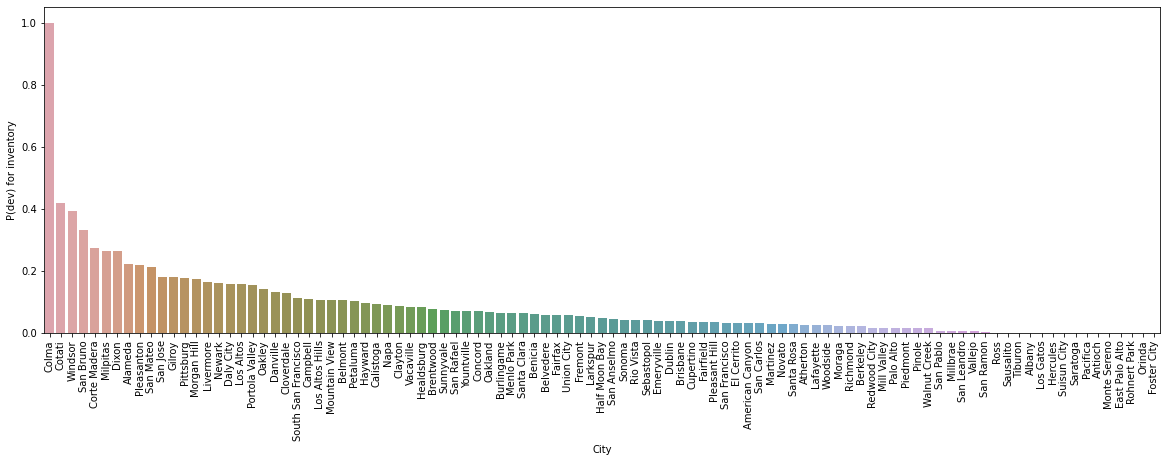

In [67]:
cities_sorted = results_both_df.sort_values('P(dev) for inventory', ascending=False)['City'].values
plt.figure(figsize=(20, 6))
ax = sea.barplot(x="City", y="P(dev) for inventory", orient="vertical",
            data=results_both_df, saturation=.5,
            order=cities_sorted)
ax.tick_params(axis='x', labelrotation=90)
plt.savefig(f'figures/pdev_by_city.jpg')

In [68]:
all_df = combined_df.merge(
    results_both_df,
    on='City',
    suffixes=['', ' union']
)

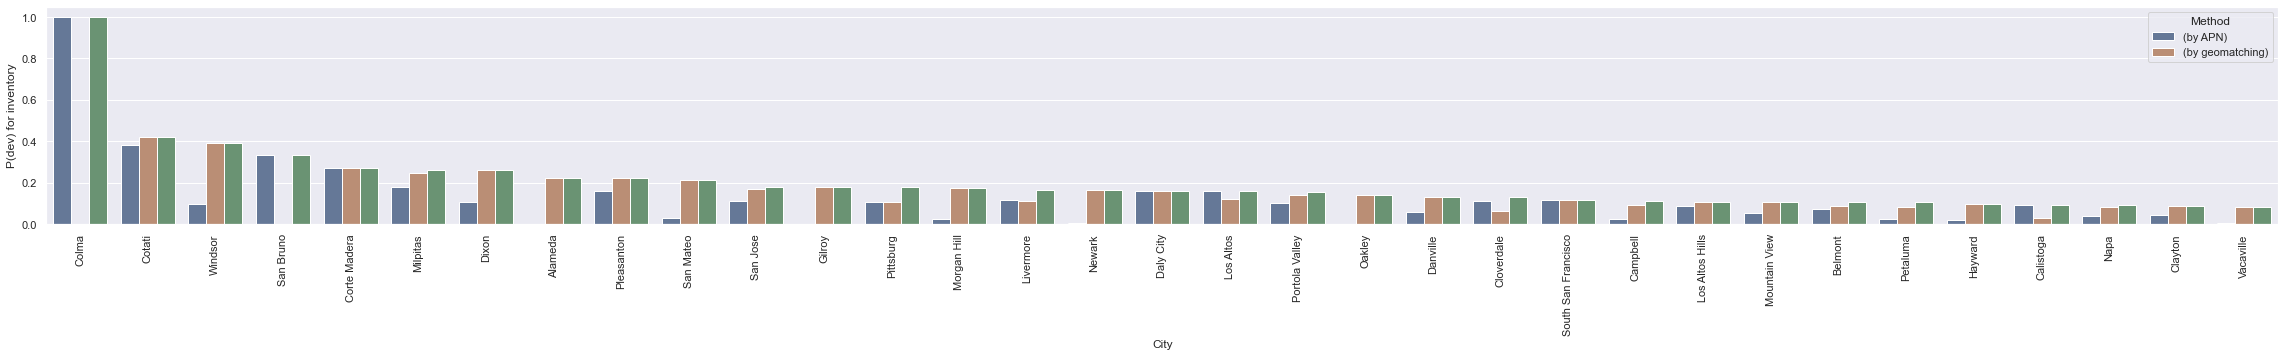

In [69]:
reload(utils)
utils.catplot_qoi(all_df, 'P(dev) for inventory', cities_sorted)

In [70]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [71]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by APN)'] - combined_df['P(dev) for nonvacant sites (by geomatching)']).abs() > 0.3
]

City  Ratio of development on inventory sites (by APN)  \
50       San Bruno                                          0.463822   
59           Colma                                          2.884615   
65  Portola Valley                                          0.585185   
98         Windsor                                          0.161681   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
50                      0.426667                                  0.128000   
59                      2.538462                                  0.880000   
65                      1.375000                                  0.139241   
98                           NaN                                  0.025000   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
50                             0.333333                               NaN   
59                             1.000000                               NaN   
65                             0.000000                          0.105263   
98                             0.106383                          0.000000   

    P(dev) for inventory (by APN) # nonvacant matches (by APN)  \
50                       0.333333                        2 / 6   
59                       1.000000                        1 / 1   
65                       0.102564                        0 / 2   
98                       0.098039                       5 / 47   

   # vacant matches (by APN) # matches (by APN)  \
50                     0 / 0              2 / 6   
59                     0 / 0              1 / 1   
65                    8 / 76             8 / 78   
98                     0 / 4             5 / 51   

    Ratio of development on inventory sites (by geomatching)  \
50                                           0.463822          
59                                           2.884615          
65                                           0.585185          
98                                           0.161681          

    Mean overproduction (by geomatching)  \
50                              0.426667   
59                              2.538462   
65                              1.375000   
98                                   NaN   

    Inventory housing / all housing (by geomatching)  \
50                                          0.128000   
59                                          0.880000   
65                                          0.139241   
98                                          0.025000   

    P(dev) for nonvacant sites (by geomatching)  \
50                                     0.000000   
59                                     0.000000   
65                                     1.000000   
98                                     0.425532   

    P(dev) for vacant sites (by geomatching)  \
50                                       NaN   
59                                       NaN   
65                                  0.118421   
98                                  0.000000   

    P(dev) for inventory (by geomatching)  \
50                               0.000000   
59                               0.000000   
65                               0.141026   
98                               0.392157   

   # nonvacant matches (by geomatching) # vacant matches (by geomatching)  \
50                                0 / 6                             0 / 0   
59                                0 / 1                             0 / 0   
65                                2 / 2                            9 / 76   
98                              20 / 47                             0 / 4   

   # matches (by geomatching)  
50                      0 / 6  
59                      0 / 1  
65                    11 / 78  
98                    20 / 51

In [72]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.797979797979798
P(dev) for vacant sites 0.7272727272727273
P(dev) for inventory 0.8181818181818182


In [73]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.40404040404040403
P(dev) for vacant sites 0.3838383838383838
P(dev) for inventory 0.36363636363636365


# "Ground truth" data

In [74]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [75]:
permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (22,31,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Estimated Cost',
       'Revised Cost', 'Existing Use', 'Existing Units', 'Proposed Use',
       'Proposed Units', 'Plansets', 'TIDF Compliance',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Record ID'],
      dtype='object')


In [76]:
print(permits.columns)

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Estimated Cost',
       'Revised Cost', 'Existing Use', 'Existing Units', 'Proposed Use',
       'Proposed Units', 'Plansets', 'TIDF Compliance',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Record ID'],
      dtype='object')


In [77]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco', 'San Jose']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['num_l', 'county', 'jurisdict', 'rhnayrs', 'allowlow', 'num_vl', 'num_am', 'infcapcty', 'rhnacyc', 'num_m']
DF shape (57, 29)
Total units permitted: 532
Total realistic capacity in inventory: 257.5
Units permitted on inventory sites: 34
Total units permitted: 532


<timed exec>:2: DtypeWarning: Columns (18,22,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/san_francisco_permits.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhna_permits.sort_values(by="Permit Type", axis=0, inplace=True)


Dropping constant columns: ['currunits', 'num_l', 'county', 'jurisdict', 'rhnayrs', 'allowlow', 'num_vl', 'num_am', 'rhnacyc', 'num_m']
DF shape (6158, 29)
Total units permitted: 26071
Total realistic capacity in inventory: 47209
Units permitted on inventory sites: 5079
Total units permitted: 26071
Dropping constant columns: ['currunits', 'num_l', 'county', 'jurisdict', 'rhnayrs', 'allowlow', 'num_vl', 'num_am', 'rhnacyc', 'num_m']
DF shape (599, 29)
Total units permitted: 16928.0
Total realistic capacity in inventory: 35536.43
Units permitted on inventory sites: 5011.0
Total units permitted: 16928.0
CPU times: user 1min 7s, sys: 3.38 s, total: 1min 11s
Wall time: 1min 40s


In [78]:
ground_truth_results_df

City  Ratio of development on inventory sites  \
0      Los Altos                                 2.066019   
1  San Francisco                                 0.552246   
2       San Jose                                 0.476356   

   Mean overproduction  Inventory housing / all housing  \
0             0.944444                         0.063910   
1             4.676239                         0.194814   
2             1.097829                         0.296018   

         P(dev) for nonvacant sites           P(dev) for vacant sites  \
0      (3, 34, 0.08823529411764706)       (6, 23, 0.2608695652173913)   
1  (95, 3915, 0.024265644955300127)  (50, 1339, 0.037341299477221805)   
2    (53, 393, 0.13486005089058525)    (14, 206, 0.06796116504854369)   

                P(dev) for inventory  
0       (9, 57, 0.15789473684210525)  
1  (145, 5254, 0.027598020555767034)  
2     (67, 599, 0.11185308848080133)

# Summary stats for report

In [86]:
len(results_both_df)

99

In [91]:
results_both_df

City  Ratio of development on inventory sites  \
0       Berkeley                                 0.348286   
1         Albany                                 0.633907   
2        Alameda                                 0.534967   
3      Livermore                                 0.576723   
4        Fremont                                 0.875979   
..           ...                                      ...   
94  Monte Sereno                                 1.424242   
95    Healdsburg                                 0.511247   
96     Fairfield                                 0.320087   
97        Sonoma                                 0.181818   
98       Windsor                                 0.161681   

    Mean overproduction  Inventory housing / all housing  \
0              1.255423                         0.040620   
1                   NaN                         0.000000   
2                   NaN                         0.000000   
3              1.238385                         0.244980   
4              0.437540                         0.112126   
..                  ...                              ...   
94                  NaN                         0.000000   
95             0.278571                         0.028000   
96             0.300000                         0.001461   
97             0.102564                         0.028571   
98                  NaN                         0.025000   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
0                     0.017964                 0.025316              0.022277   
1                     0.000000                 0.000000              0.000000   
2                     0.142857                 0.272727              0.222222   
3                     0.090909                 0.233010              0.163366   
4                     0.049645                 0.095238              0.055556   
..                         ...                      ...                   ...   
94                    0.000000                      NaN              0.000000   
95                    0.083333                 0.083333              0.083333   
96                    0.000000                 0.038961              0.034884   
97                    0.000000                 0.200000              0.043478   
98                    0.425532                 0.000000              0.392157   

   # nonvacant matches # vacant matches # matches  
0              3 / 167          6 / 237   9 / 404  
1               0 / 33            0 / 8    0 / 41  
2                1 / 7           3 / 11    4 / 18  
3               9 / 99         24 / 103  33 / 202  
4              7 / 141           2 / 21   9 / 162  
..                 ...              ...       ...  
94               0 / 6            0 / 0     0 / 6  
95              2 / 24           3 / 36    5 / 60  
96               0 / 9           3 / 77    3 / 86  
97              0 / 18            1 / 5    1 / 23  
98             20 / 47            0 / 4   20 / 51  

[99 rows x 10 columns]

In [100]:
results_both_df.sample(10)

City  Ratio of development on inventory sites  \
44        Belvedere                                 0.235294   
28     Corte Madera                                 0.573770   
96        Fairfield                                 0.320087   
66           Gilroy                                 2.573668   
33        Pittsburg                                 0.383562   
12          Concord                                 0.060377   
42       Yountville                                 0.211268   
52         Brisbane                                 0.104084   
69  Los Altos Hills                                 0.401685   
71    Mountain View                                 1.112873   

    Mean overproduction  Inventory housing / all housing  \
44             1.000000                         0.250000   
28             1.000000                         0.514286   
96             0.300000                         0.001461   
66                  NaN                         0.000000   
33             1.326263                         0.293177   
12             0.538889                         0.045833   
42                  NaN                         0.000000   
52             1.604167                         0.253165   
69             0.755952                         0.139860   
71             8.753160                         0.183850   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
44                         NaN                 0.058824              0.058824   
28                    0.000000                 0.300000              0.272727   
96                    0.000000                 0.038961              0.034884   
66                    0.205882                 0.000000              0.179487   
33                    0.090909                 0.235294              0.178571   
12                    0.044674                 0.166667              0.070461   
42                    0.000000                 0.111111              0.071429   
52                    0.029508                 0.061404              0.038186   
69                    0.088710                 0.266667              0.107914   
71                    0.093023                 0.285714              0.107527   

   # nonvacant matches # vacant matches # matches  
44               0 / 0           1 / 17    1 / 17  
28               0 / 1           3 / 10    3 / 11  
96               0 / 9           3 / 77    3 / 86  
66              7 / 34            0 / 5    7 / 39  
33              1 / 11           4 / 17    5 / 28  
12            13 / 291          13 / 78  26 / 369  
42               0 / 5            1 / 9    1 / 14  
52             9 / 305          7 / 114  16 / 419  
69            11 / 124           4 / 15  15 / 139  
71              8 / 86            2 / 7   10 / 93

In [99]:
for col in ['# matches', '# nonvacant matches', '# vacant matches']:
    values = results_both_df[col]
    num = values.str.split('/').apply(lambda x: int(x[0]))
    denom = values.str.split('/').apply(lambda x: int(x[1]))
    print(col)
    print('{:.1%}'.format(num.sum() / denom.sum()))
    print()

# matches
6.1%

# nonvacant matches
5.7%

# vacant matches
6.9%



In [90]:
for col in ['P(dev) for vacant sites', 'P(dev) for nonvacant sites', 'P(dev) for inventory']:
    values = results_both_df[col]
    print(col)
    print('Median: {:.1%}'.format(8/5 * values.median()))
    print('Mean: {:.1%}'.format(8/5 * values.mean()))
    display(
        pd.cut(
            8/5 * values, 
            [0, 0.1, 0.25, 0.5, 1],
            right=False
        ).value_counts()
    )
    print()

P(dev) for vacant sites
Median: 9.4%
Mean: 17.8%


[0.0, 0.1)     44
[0.1, 0.25)    17
[0.25, 0.5)    16
[0.5, 1.0)      5
Name: P(dev) for vacant sites, dtype: int64


P(dev) for nonvacant sites
Median: 5.6%
Mean: 13.9%


[0.0, 0.1)     56
[0.1, 0.25)    22
[0.25, 0.5)     7
[0.5, 1.0)      2
Name: P(dev) for nonvacant sites, dtype: int64


P(dev) for inventory
Median: 8.4%
Mean: 14.2%


[0.0, 0.1)     54
[0.1, 0.25)    25
[0.25, 0.5)    14
[0.5, 1.0)      3
Name: P(dev) for inventory, dtype: int64